## Import

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

In [5]:
for i in enumerate(bank_marketing.variables[['description']].values):
    print(i)

(0, array([None], dtype=object))
(1, array(["type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"],
      dtype=object))
(2, array(["marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"],
      dtype=object))
(3, array(["(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"],
      dtype=object))
(4, array(['has credit in default?'], dtype=object))
(5, array(['average yearly balance'], dtype=object))
(6, array(['has housing loan?'], dtype=object))
(7, array(['has personal loan?'], dtype=object))
(8, array(["contact communication type (categorical: 'cellular','telephone') "],
      dtype=object))
(9, array(['last contact day of the week'], dtype=object))
(10, array(["last contact month of year (categorical: 'jan', 'feb', 'mar', ..., '

The maintainers suggest leaving out `duration`.

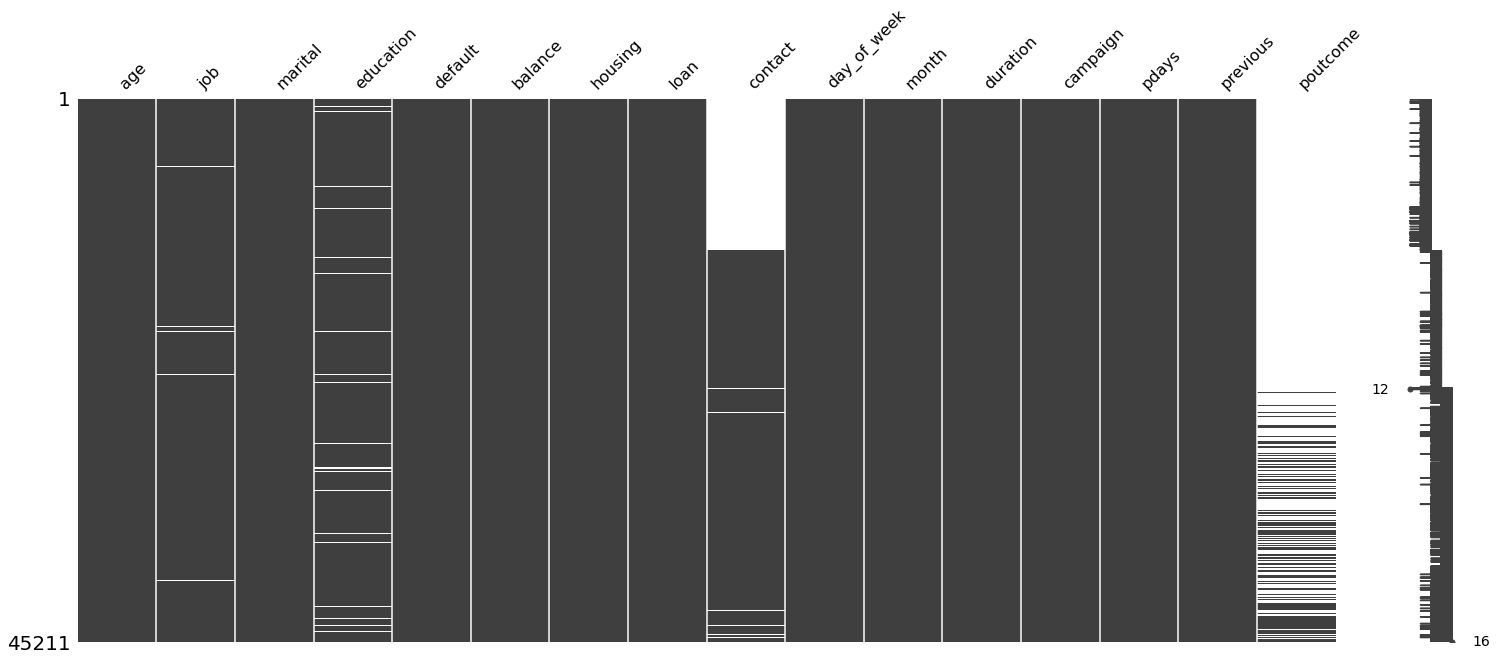

In [26]:
msno.matrix(X);

I will drop `poutcome` because there are mostly missing values. But first:

## More EDA

### Features

#### Numeric features

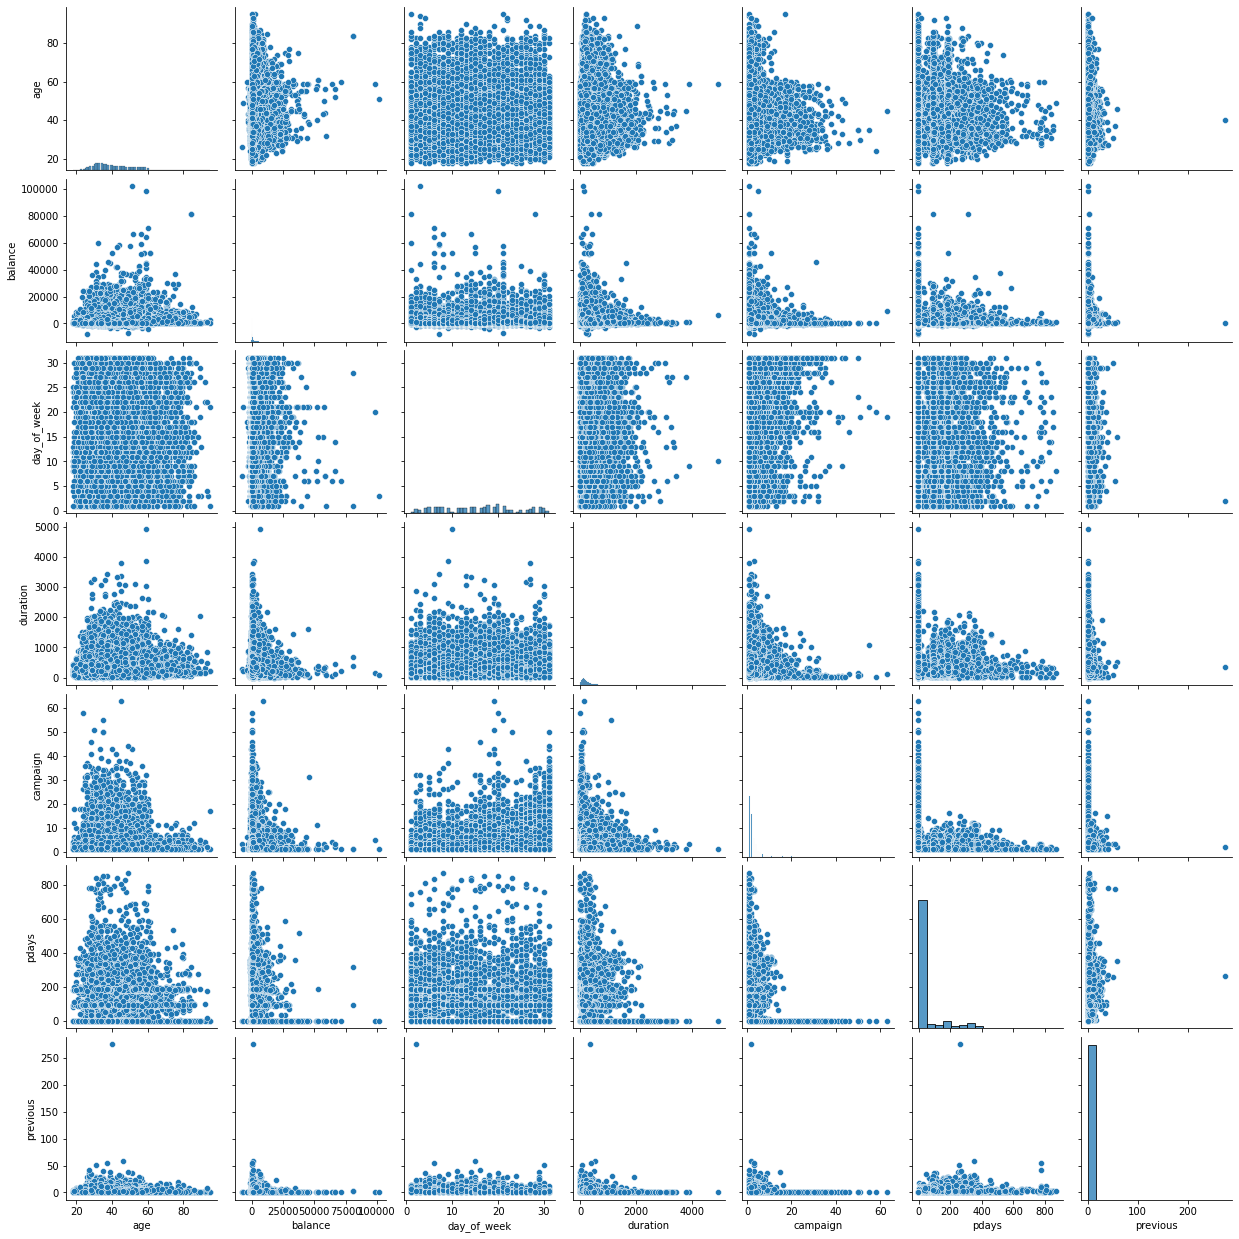

In [6]:
sns.pairplot(X.select_dtypes('int64'));


C:\Users\barne\AppData\Local\Temp\ipykernel_1140\2763493664.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X.corr());


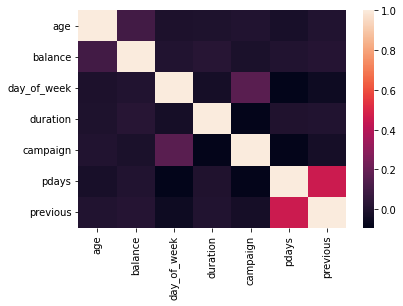

In [28]:
sns.heatmap(X.corr());

The largest correlation is between `pdays` and `previous`. There might be some redundancy in those measures. From the feature descriptions, `pdays = -1` and `previous = 0` describe a similar situation.

#### Categorical features

In [11]:
X['contact'].value_counts().index

Index(['cellular', 'telephone'], dtype='object')

C:\Users\barne\AppData\Local\Temp\ipykernel_1140\3248383479.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(rotation = 90, labels=[str(x) for x in X[i].value_counts().index.values])
C:\Users\barne\AppData\Local\Temp\ipykernel_1140\3248383479.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(rotation = 90, labels=[str(x) for x in X[i].value_counts().index.values])
C:\Users\barne\AppData\Local\Temp\ipykernel_1140\3248383479.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(rotation = 90, labels=[str(x) for x in X[i].value_counts().index.values])
C:\Users\barne\AppData\Local\Temp\ipykernel_1140\3248383479.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(rotation = 90, labels=[str(x) for x in X[i].value_counts().index.values])
C:\Users\barne\AppData\Local\Temp\ipykernel_1140\324

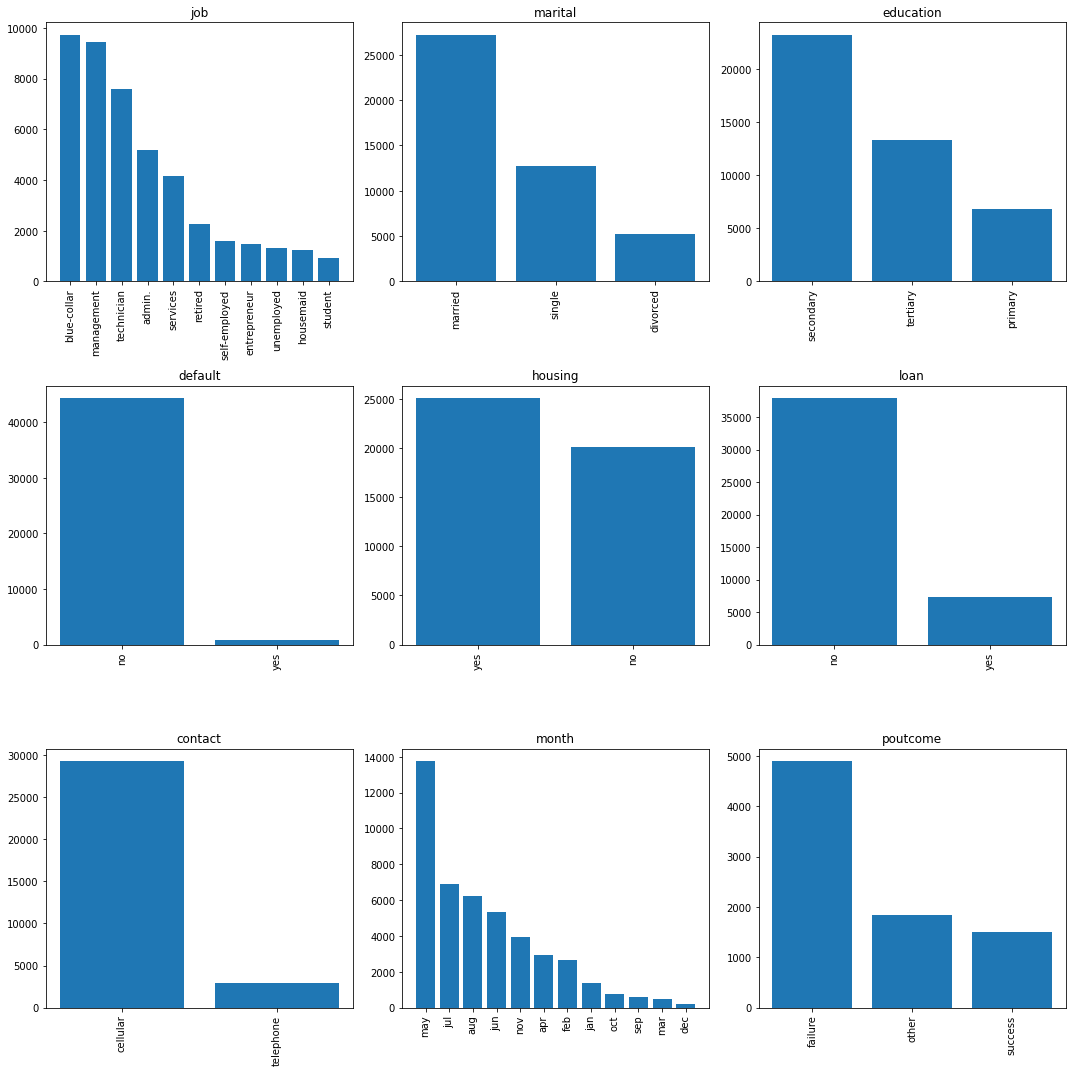

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i, axs in zip(X.select_dtypes('object').columns, fig.axes):
    #sns.barplot(X[i], ax=axs)
    axs.bar(X[i].value_counts().index.values, height=X[i].value_counts().values)
    axs.set_title(i)
    axs.set_xticklabels(rotation=90, labels=[str(x) for x in X[i].value_counts().index.values])

fig.tight_layout()

There are biases present in the categorical data.

### Target

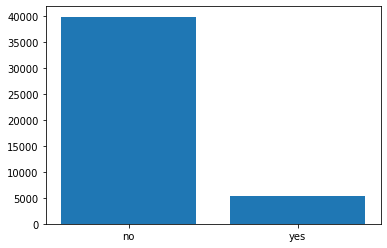

In [42]:
plt.bar(y['y'].value_counts().index.values, height=y['y'].value_counts().values);

The target is baised to `no` oucome values.

### Modeling/preprocessing decisions based on EDA and planned model types:
- the numeric categories need to be scaled
  - standard scaling
- categories need to be recoded
  - one-hot encoding for k-1 groups/feature
- imputing `contact` after low-quality rows droped, certain columns removed, and all values coded to numeric.
- train/test/validation split (%)
  - 70/15/15 for classification reports
  - cv=5/15 for specific scores (`roc_auc_score`, `precision_score`)
- scoring metrics for hyperparameter tuning
  - `roc_auc_score` for Logistic regression
  - `log_loss` for Decision tree and Random forest.
- models should account for the imbalance in the target variable
  - `class_weight='balanced'` will help models to not over-emphasize the `no` outcome during training.
  - I want to use resampling strategies from `imblearn`

## Preprocessing

### Data removal

Dropping rows with more than two missing values.

In [43]:
na_list = []

for i in range(len(X)):
    na_list.append(X.iloc[i].isna().sum())

In [44]:
X2 = X.copy()
X2['isna'] = na_list

In [45]:
X2 = X2[X2['isna'] < 3]
X2.drop(columns=['isna'], inplace=True)

y2 = y.copy()
y2['isna'] = na_list
y2 = y2[y2['isna'] < 3]
y2.drop(columns=['isna'], inplace=True)

Dropping columns

In [46]:
X2.drop(columns=['duration', 'poutcome'], inplace=True)

<AxesSubplot: >

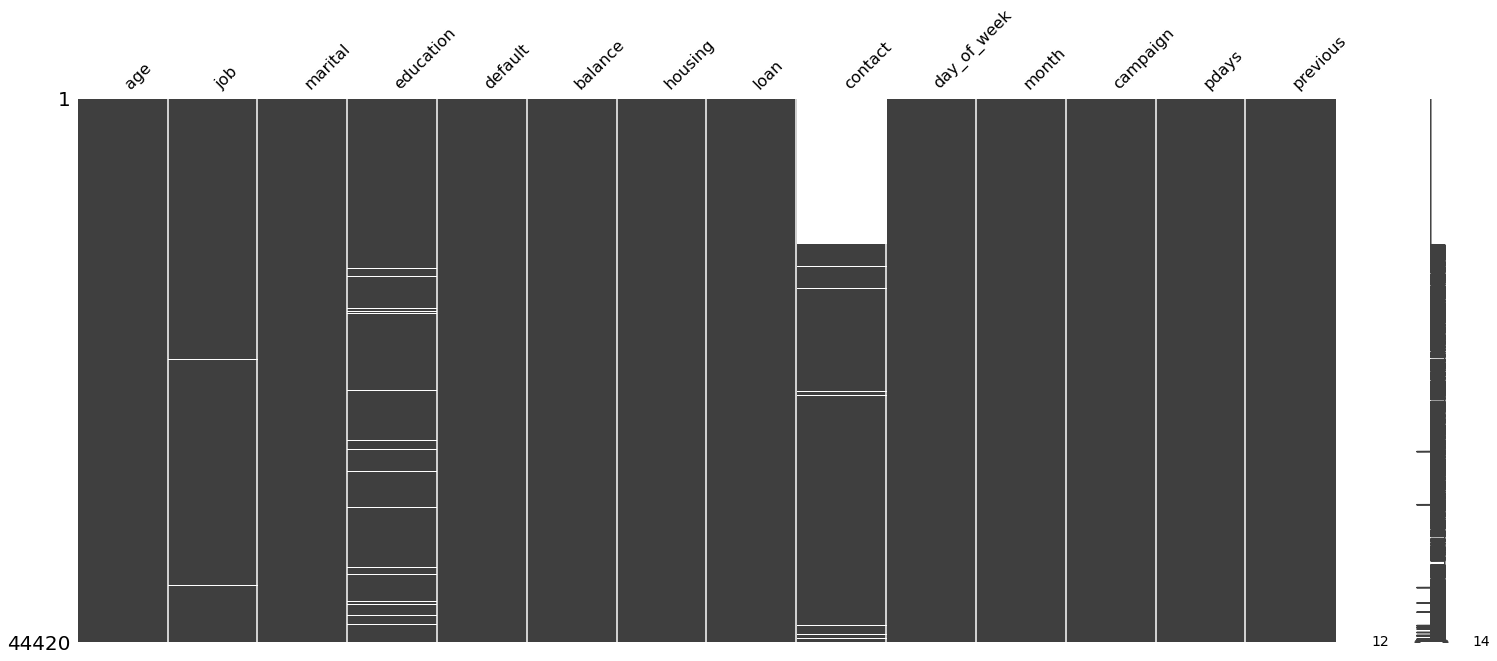

In [47]:
msno.matrix(X2)

In [48]:
X2.to_csv('./data_t2/X')
y2.to_csv('./data_t2/y')

Rewrite the objects in the kernel/session.

In [49]:
X = pd.read_csv('./data_t2/X').drop(columns='Unnamed: 0')
y = pd.read_csv('./data_t2/y').drop(columns='Unnamed: 0')

### Feature engineering

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib


In [51]:
cols_num = list(X.select_dtypes('int64').columns)
cols_cat = list(X.select_dtypes('object').columns)

In [52]:
pipeline_num = Pipeline([
    ("std_scaler", StandardScaler())
])

In [53]:
X_num = pipeline_num.fit_transform(X[cols_num])
X_num = pd.DataFrame(data=X_num, columns=cols_num)

X_cat = pd.get_dummies(X[cols_cat], drop_first=True, dummy_na=True)

In [54]:
nan_cols = [x + "_nan" for x in cols_cat]

for i in nan_cols:
    if X_cat[i].sum() == 0:
        X_cat.drop(columns=i, inplace=True)

Recoding to retain the nan values in `contact_telephone`.

In [55]:
contact_vals = []
for i in range(X_cat.shape[0]):
    if (X_cat['contact_nan'][i] == 1):
        contact_vals.append(np.nan)
    else:
        contact_vals.append(X_cat['contact_telephone'][i])

X_cat['contact_telephone'] = contact_vals

In [56]:
X_data = pd.concat([X_num, X_cat], axis=1)

y_data = pd.get_dummies(y, drop_first=True)

data_df = pd.concat([X_data, y_data], axis=1)

### Imputing `contact`

In [57]:
from sklearn.impute import KNNImputer

In [58]:
imputer = KNNImputer(n_neighbors=3)

imp_result = imputer.fit_transform(data_df)

impute_data_df = pd.DataFrame(data=imp_result, columns=list(data_df.columns))

#### View `contact` imputation results

In [59]:
data_df[X_data['contact_telephone'].isnull()].head()

,age,balance,day_of_week,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_yes
0,1.613355,0.256909,-1.300543,-0.57199,-0.415727,-0.254317,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.295138,-0.437485,-1.300543,-0.57199,-0.415727,-0.254317,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.740603,-0.446353,-1.300543,-0.57199,-0.415727,-0.254317,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-0.552287,-0.371133,-1.300543,-0.57199,-0.415727,-0.254317,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,-1.211395,-0.300182,-1.300543,-0.57199,-0.415727,-0.254317,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


<AxesSubplot: xlabel='contact_telephone', ylabel='Count'>

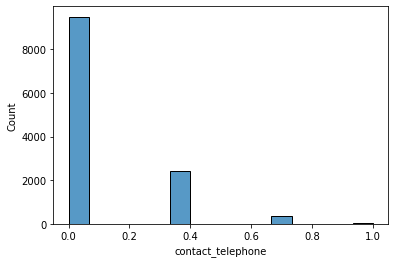

In [60]:
sns.histplot(impute_data_df[X_data['contact_telephone'].isnull()]['contact_telephone'])

Most values imputed as `0` (meaning cellular) with some as intermediate values between 1 and 0. This makes sense because of how biased `contact` is.  Rounding the intermediate values next:

In [61]:
imputed_vals = []

for i in range(impute_data_df.shape[0]):
    if impute_data_df['contact_telephone'][i] < 0.5:
        imputed_vals.append(0)
    else:
        imputed_vals.append(1)

impute_data_df['contact_telephone'] = imputed_vals

In [ ]:
impute_data_df = impute_data_df.drop(columns='contact_nan')

## Shuffling train/test/validation sets

In [62]:
#shuffling the data

data_df = impute_data_df.sample(frac=1, random_state=42).reset_index(drop=True)

#arrange columns by how the app is configured
X_input = pd.read_csv('./data_t2/input.csv').drop(columns='Unnamed: 0')
data_df = data_df.reindex(list(X_input.columns.values).append("y_yes"), axis=1)

In [63]:
#validation-test set

validation_test_df = data_df.sample(frac=0.3, random_state=42)

In [64]:
#splitting into validation and test sets
test_df = validation_test_df.sample(frac=0.5, random_state=42)
validation_df = validation_test_df.drop(test_df.index)

print('All rows are different between validation and test sets: {}'.format(np.alltrue(test_df.index != validation_df.index)))

All rows are different between validation and test sets: True


In [65]:
test_df.to_csv('./data_t2/test_df')
validation_df.to_csv('./data_t2/validation_df')

train_df = data_df.drop(validation_test_df.index)
train_df.to_csv('./data_t2/train_df')

## Logistic regression classifier

### A base model

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score


In [67]:
train_df = pd.read_csv('./data_t2/train_df').drop(columns='Unnamed: 0')
test_df = pd.read_csv('./data_t2/test_df').drop(columns='Unnamed: 0')

In [68]:
X_train = train_df.drop(columns='y_yes')
y_train = train_df['y_yes'].ravel()

#arrange columns by how the app is configured
X_input = pd.read_csv('./data_t2/input.csv').drop(columns='Unnamed: 0')
X_train = X_train.reindex(X_input.columns, axis=1)


X_test = test_df.drop(columns='y_yes')
y_test = test_df['y_yes'].ravel()

#arrange columns by how the app is configured
X_input = pd.read_csv('./data_t2/input.csv').drop(columns='Unnamed: 0')
X_test = X_test.reindex(X_input.columns, axis=1)

In [69]:
logreg_model = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')

logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.94      0.70      0.80      5878
         yes       0.23      0.69      0.35       785

    accuracy                           0.70      6663
   macro avg       0.59      0.69      0.58      6663
weighted avg       0.86      0.70      0.75      6663



The model predicts negatives (those clients that do not subscribe a term account) much better that it predicts positives (the clients that do). For this data, we are likely more interested in accurately predicting the true positives. 

The next models will explore methods to improve predication accuracy for the true positive rate.

### Comparing sampling methods

For imbalanced learning use cases, sampling methods help to normalize the training examples for each classification class and this approach might improve positive prediction accuracy.

In [74]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

In [79]:
X = pd.concat([X_train, X_test])
y = pd.concat([train_df['y_yes'], test_df['y_yes']]).ravel()

logreg_model = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')

smote = SMOTE(random_state=42)
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_res, y_res = smote.fit_resample(X, y)
X_rus, y_rus = rus.fit_resample(X, y)

print("overampling yes(1):")
print(pd.Series(y_res).value_counts())
print("random undersampling no(0):")
print(pd.Series(y_rus).value_counts())


overampling yes(1):
0.0    33291
1.0    33291
dtype: int64
random undersampling no(0):
0.0    4466
1.0    4466
dtype: int64


In [80]:
pipeline = [
    make_pipeline(logreg_model),
    make_pipeline(rus, logreg_model),
    make_pipeline(smote, logreg_model)
]

In [75]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Code to compare sampling methods from the `imblearn` [documentation](https://imbalanced-learn.org/stable/auto_examples/applications/plot_over_sampling_benchmark_lfw.html#sphx-glr-auto-examples-applications-plot-over-sampling-benchmark-lfw-py):

In [81]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

pos_label = pd.Series(y).value_counts().idxmin()

disp = []
for model in pipeline:
    # compute the mean fpr/tpr to get the mean ROC curve
    mean_tpr, mean_fpr = 0.0, np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        logreg_model.fit(X.iloc[train], y[train])
        y_proba = logreg_model.predict_proba(X.iloc[test])

        pos_label_idx = np.flatnonzero(logreg_model.C == pos_label)[0]
        fpr, tpr, thresholds = roc_curve(
            y[test], y_proba[:, pos_label_idx], pos_label=pos_label
        )
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    # Create a display that we will reuse to make the aggregated plots for
    # all methods
    disp.append(
        RocCurveDisplay(
            fpr=mean_fpr,
            tpr=mean_tpr,
            roc_auc=mean_auc,
            estimator_name=f"{model[0].__class__.__name__}",
        )
    )

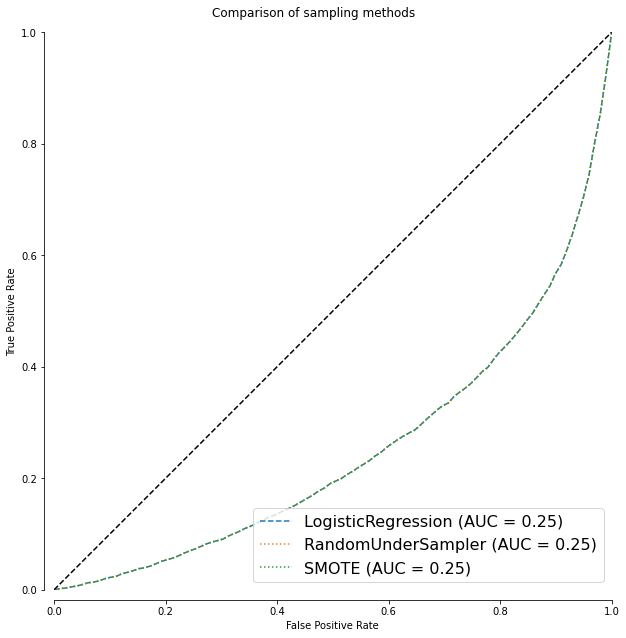

In [82]:
fig, ax = plt.subplots(figsize=(9, 9))
for d, l in zip(disp, ["--", "dotted", ":"]):
    d.plot(ax=ax, linestyle=l)
ax.plot([0, 1], [0, 1], linestyle="--", color="k")
ax.axis("square")
fig.suptitle("Comparison of sampling methods")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(offset=10, ax=ax)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

Sampling did not improve the true positive rate over the base model. The AUC is slightly higher than the previous precision score (0.23).

### Hyperparameter selection

After identifying a preprocessing pipeline for the data and model, a next step is to tune model hyperparameters to improve accuracy. The process can be for a specific prediction outcome, to maximize the true positive rate or the true negative rate. A threshold-independent metric may be used for model selection. 

In the next step, `roc_auc_score` is used to identify logistic regression hyperparameters with `GridSearchCV`.

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

In [84]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True, average=None)

In [85]:
logreg_model = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')

param_grid = {'solver': ['lbfgs', 'newton-cholesky', 'sag'],
        'C': [0.1, 1.0, 10]}

grid_search = GridSearchCV(estimator=logreg_model, param_grid=param_grid, cv=5, scoring=roc_auc_scorer)

grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42),
             param_grid={'C': [0.1, 1.0, 10],
                         'solver': ['lbfgs', 'newton-cholesky', 'sag']},
             scoring=make_scorer(roc_auc_score, needs_threshold=True, average=None))

In [86]:
grid_search.best_score_, grid_search.best_params_

(0.7493043250512693, {'C': 0.1, 'solver': 'sag'})

The search found regularization with `C=0.1` and `solver=sag` to be optimal from the hyperparameter grid.

### Threshold tuning

For threshold tuning, I will emphasize positive precision accuracy without substantially detrimenting overall model performance using `precision_score` and `roc_auc_score`.

In [87]:
logreg_model = LogisticRegression(
    random_state=42, 
    max_iter=10000, 
    class_weight='balanced', 
    C=0.1, 
    solver='sag'
)

logreg_model.fit(X_train, y_train)

pred_proba_df = pd.DataFrame(logreg_model.predict_proba(X_test))

thresholds = np.arange(0, 1, 0.02)

pre_score = []
roc_score = []

for i in thresholds:
    y_pred = pred_proba_df[1].apply(lambda x: 1 if x > i else 0)
    pre_score.append(precision_score(y_test, y_pred, average='binary', pos_label=1))
    roc_score.append(roc_auc_score(y_test, y_pred))

score_df = pd.DataFrame({'precision': pre_score,
                         'roc_auc': roc_score,
                         'threshold': thresholds
                         })
                    

c:\Users\barne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
idx = score_df\
    [score_df['roc_auc'] > (score_df['roc_auc'].max() - 0.025)]\
    .idxmax()['precision']

score_df.iloc[idx]

precision    0.346266
roc_auc      0.670056
threshold    0.620000
Name: 31, dtype: float64

Within 0.025 margin of model prediction performance, positive precision could be increased to ~0.35 using a threshold of 0.62 probability to assign a `yes` label to an outcome. Finally, I will use this threshold in a final classification report on the validation dataset.

### Final model metrics

In [89]:
validation_df = pd.read_csv('./data_t2/validation_df').drop(columns='Unnamed: 0')

X_val = validation_df.drop(columns='y_yes')
y_val = validation_df['y_yes'].ravel()

#arrange columns by how the app is configured
X_input = pd.read_csv('./data_t2/input.csv').drop(columns='Unnamed: 0')
X_val = X_val.reindex(X_input.columns, axis=1)

In [90]:
logreg_model = LogisticRegression(
    random_state=42, 
    max_iter=10000, 
    class_weight='balanced', 
    C=0.1, 
    solver='sag'
)

logreg_model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000,
                   random_state=42, solver='sag')

In [91]:
y_pred_test = logreg_model.predict(X_test)
y_pred_proba_test = pd.DataFrame(logreg_model.predict_proba(X_test))

y_pred_val = logreg_model.predict(X_val)
y_pred_proba_val = pd.DataFrame(logreg_model.predict_proba(X_val))

predictions with threshold 0.62

In [92]:
y_pred_test2 = y_pred_proba_test[1].apply(lambda x: 1 if x > 0.62 else 0)

y_pred_val2 = y_pred_proba_val[1].apply(lambda x: 1 if x > 0.62 else 0)

#### Predictions by threshold

In [93]:
print('Scores for the Test subset:\nThreshold = 0.50')
print(classification_report(y_test, y_pred_test))
print('Threshold = 0.62')
print(classification_report(y_test, y_pred_test2))

Scores for the Test subset:
Threshold = 0.50
              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80      5878
         1.0       0.23      0.68      0.35       785

    accuracy                           0.70      6663
   macro avg       0.59      0.69      0.57      6663
weighted avg       0.86      0.70      0.75      6663

Threshold = 0.62
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      5878
         1.0       0.35      0.45      0.39       785

    accuracy                           0.83      6663
   macro avg       0.64      0.67      0.65      6663
weighted avg       0.86      0.83      0.84      6663



In [94]:
print('Scores for the Validation subset:\nThreshold = 0.50')
print(classification_report(y_val, y_pred_val))
print('Threshold = 0.62')
print(classification_report(y_val, y_pred_val2))

Scores for the Validation subset:
Threshold = 0.50
              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80      5872
         1.0       0.23      0.69      0.35       791

    accuracy                           0.69      6663
   macro avg       0.59      0.69      0.57      6663
weighted avg       0.86      0.69      0.74      6663

Threshold = 0.62
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      5872
         1.0       0.36      0.47      0.41       791

    accuracy                           0.84      6663
   macro avg       0.65      0.68      0.66      6663
weighted avg       0.86      0.84      0.85      6663



So far, I have used a single model type to predict term subscription. While other optimization steps can be taken for logistic regression (multicollinearity, feature selection), other model types could offer better predictions or tunability over the dataset.

## Decision tree classifier

### A base model

In [95]:
from sklearn.tree import DecisionTreeClassifier

In [96]:
custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label=1, average='binary')

In [97]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

X = pd.concat([X_train, X_test])
y = pd.concat([train_df['y_yes'], test_df['y_yes']]).ravel()

roc_cv = cross_val_score(estimator=dt_model, X=X, y=y, cv=5, scoring=roc_auc_scorer)
precision_cv = cross_val_score(estimator=dt_model, X=X, y=y, cv=5, scoring=custom_scorer)

Unweighted mean ROC AUC and true positive (precision) scores with standard deviation. The unweighted score is considers `no` and `yes` outcomes equally and the true positive portion is reported alongside. relatively high variance indicates overfitting and reduced generalizeability of a trained model to test data.

In [98]:
print(u'  roc_auc_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(roc_cv), np.std(roc_cv)))
print(u'precision_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(precision_cv), np.std(precision_cv)))

  roc_auc_score: 0.59 ± 0.009
precision_score: 0.27 ± 0.015


Simultaneous scoring metrics over a single train-test split.

In [99]:
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      5878
         1.0       0.30      0.30      0.30       785

    accuracy                           0.83      6663
   macro avg       0.60      0.60      0.60      6663
weighted avg       0.83      0.83      0.83      6663



In [100]:
print(confusion_matrix(y_test, y_pred))

[[5314  564]
 [ 547  238]]


A default decision tree model has already achieved slightly better positive precision (~0.27) than a default logistic regression model (~0.23).

Next, I will check the influence of some hyperparameters on decision tree model accuracy. I will use `log_loss` to tune parameters because of the risk to converge on an overfit model with decision trees when maximizing accuracy score.

### hyperparameter tuning

In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss

In [102]:
log_losser = make_scorer(log_loss, greater_is_better=False, needs_proba=True) 

In [103]:
param_grid = {
    'max_features': [None, "sqrt"],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [None, 5, 10, 15],
    'criterion': ['gini', 'entropy']
}

dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring=log_losser)

In [104]:
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 2, 3]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

In [105]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 3}

In [106]:
dt_model = DecisionTreeClassifier(
    random_state=42, 
    class_weight='balanced',
    max_depth=5,
    max_features=None,
    min_samples_leaf=3,
    criterion='gini'
)

In [107]:
roc_cv = cross_val_score(estimator=dt_model, X=X, y=y, cv=5, scoring=roc_auc_scorer)
precision_cv = cross_val_score(estimator=dt_model, X=X, y=y, cv=5, scoring=custom_scorer)

In [108]:
print(u'  roc_auc_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(roc_cv), np.std(roc_cv)))
print(u'precision_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(precision_cv), np.std(precision_cv)))

  roc_auc_score: 0.73 ± 0.009
precision_score: 0.30 ± 0.006


The true positive precision has slightly increased and the variance has decreased compared to the base model.

### Final model metrics

In [109]:
validation_df = pd.read_csv('./data_t2/validation_df').drop(columns='Unnamed: 0')

X_val = validation_df.drop(columns='y_yes')
y_val = validation_df['y_yes'].ravel()

#arrange columns by how the app is configured
X_input = pd.read_csv('./data_t2/input.csv').drop(columns='Unnamed: 0')
X_val = X_val.reindex(X_input.columns, axis=1)

In [110]:
y_pred_test = grid_search.best_estimator_.predict(X_test)

y_pred_val = grid_search.best_estimator_.predict(X_val)

print("Test subset classification:")
print(classification_report(y_test, y_pred_test))
print("Validation subset classification:")
print(classification_report(y_val, y_pred_val))

Test subset classification:
              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88      5878
         1.0       0.31      0.54      0.40       785

    accuracy                           0.81      6663
   macro avg       0.62      0.69      0.64      6663
weighted avg       0.86      0.81      0.83      6663

Validation subset classification:
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      5872
         1.0       0.30      0.54      0.38       791

    accuracy                           0.79      6663
   macro avg       0.61      0.68      0.63      6663
weighted avg       0.86      0.79      0.82      6663



The model performed just as well on unseen validation data when compared to test data.

A random forest model reduces the variance of decision trees by aggregating predictions from multiple, random decision trees. Next, I will check whether a random forest model can improve predictions over the dataset.

## Random forest classifier

### A base model

In [111]:
from sklearn.ensemble import RandomForestClassifier

In [112]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      5878
         1.0       0.53      0.14      0.22       785

    accuracy                           0.88      6663
   macro avg       0.71      0.56      0.58      6663
weighted avg       0.85      0.88      0.85      6663



In [113]:
roc_cv = cross_val_score(estimator=rf_model, X=X, y=y, cv=5, scoring=roc_auc_scorer)
precision_cv = cross_val_score(estimator=rf_model, X=X, y=y, cv=5, scoring=custom_scorer)

In [114]:
print(u'roc_auc_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(roc_cv), np.std(roc_cv)))
print(u'precision_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(precision_cv), np.std(precision_cv)))

roc_auc_score: 0.77 ± 0.006
precision_score: 0.57 ± 0.027


So far, there has been improvement in positive precision scores moving across the default Logistic regression, Decision tree, and then Random forest classifiers (~0.23 -> ~0.27 -> ~0.57). At the same time, positive recall has decreased (~0.69 -> ~0.30 -> ~0.14). It is likely that a large increase in true positive prediction is a result of overfitting, as the variance is relatively large. Hyperparameter selection will use `log-loss` to reduce the risk of overfitting.

### Hyperparameter selection

In [115]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


#### Concurrent random under sampling

In [119]:
clf = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority', random_state=42),
    GridSearchCV(
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        param_grid={
            'max_features': [None, "sqrt"],
            'min_samples_leaf': [1, 2, 3],
            'max_depth': [None, 5, 10, 15],
            'n_estimators': [50, 100, 150]
        },
        cv=3,
        verbose=3,
        refit=True,
        scoring=log_losser
    )
)

In [120]:
clf.fit(X, y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50;, score=-0.626 total time=   3.7s
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50;, score=-0.617 total time=   3.7s
[CV 3/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50;, score=-0.600 total time=   3.1s
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=-0.576 total time=   5.9s
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=-0.588 total time=   6.3s
[CV 3/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=-0.592 total time=   7.6s
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=150;, score=-0.575 total time= 1.4min
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=150;, score=-0.585 total ti

Pipeline(steps=[('randomundersampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('gridsearchcv',
                 GridSearchCV(cv=3,
                              estimator=RandomForestClassifier(class_weight='balanced',
                                                               random_state=42),
                              param_grid={'max_depth': [None, 5, 10, 15],
                                          'max_features': [None, 'sqrt'],
                                          'min_samples_leaf': [1, 2, 3],
                                          'n_estimators': [50, 100, 150]},
                              scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
                              verbose=3))])

In [121]:
param_index = pd.Series(clf.get_params()).index[pd.Series(clf.get_params()).index.str.contains('gridsearchcv__estimator')]

pd.Series(clf.get_params())[param_index]

gridsearchcv__estimator__bootstrap                                                                True
gridsearchcv__estimator__ccp_alpha                                                                 0.0
gridsearchcv__estimator__class_weight                                                         balanced
gridsearchcv__estimator__criterion                                                                gini
gridsearchcv__estimator__max_depth                                                                None
gridsearchcv__estimator__max_features                                                             sqrt
gridsearchcv__estimator__max_leaf_nodes                                                           None
gridsearchcv__estimator__max_samples                                                              None
gridsearchcv__estimator__min_impurity_decrease                                                     0.0
gridsearchcv__estimator__min_samples_leaf                                

In [130]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_valrus, y_valrus = rus.fit_resample(X_val, y_val)

y_pred_val = clf.predict(X_valrus)

print(classification_report(y_valrus, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.69      0.76      0.72       791
         1.0       0.73      0.66      0.70       791

    accuracy                           0.71      1582
   macro avg       0.71      0.71      0.71      1582
weighted avg       0.71      0.71      0.71      1582



In [131]:
rf_model = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',
    max_features='sqrt',
    n_estimators=100 
)

In [132]:
X_rus, y_rus = rus.fit_resample(X, y)

roc_cv = cross_val_score(estimator=rf_model, X=X_rus, y=y_rus, cv=5, scoring=roc_auc_scorer)
precision_cv = cross_val_score(estimator=rf_model, X=X_rus, y=y_rus, cv=5, scoring=custom_scorer)

In [133]:
print(u'  roc_auc_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(roc_cv), np.std(roc_cv)))
print(u'precision_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(precision_cv), np.std(precision_cv)))

  roc_auc_score: 0.77 ± 0.006
precision_score: 0.74 ± 0.006


This model has a much improved true positive precision with the unseed validation dataset. The variance is reduced, too, indicating the model is not overfit and it generalizes well. 

The model has lost true negative predictive power and we are also using a smaller subset of the data (with random under sampling).

#### Disjointed random under sampling strategy

Hyperparameter selection without sampling, then fitting a final model with random under sampling.

In [126]:
param_grid = {
    'max_features': [None, "sqrt"],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [None, 5, 10, 15],
    'n_estimators': [50, 100, 150]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=3,
    refit=True,
    verbose=3,
    scoring=log_losser
)

grid_search.fit(X, y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50;, score=-0.511 total time=  11.2s
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50;, score=-0.528 total time=  10.7s
[CV 3/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50;, score=-0.538 total time=  10.5s
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=-0.418 total time=  21.6s
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=-0.416 total time=  21.9s
[CV 3/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=-0.426 total time=  21.9s
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=150;, score=-0.371 total time=  33.0s
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=150;, score=-0.375 total ti

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=3)

In [134]:
grid_search.best_score_, grid_search.best_params_

(-0.33561370905741855,
 {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'n_estimators': 150})

In [135]:
rf_model = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',
    max_depth=grid_search.best_params_['max_depth'],
    max_features=grid_search.best_params_['max_features'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    n_estimators=grid_search.best_params_['n_estimators']
)

rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)

model = make_pipeline(rus, rf_model)

X_trainrus, y_trainrus = rus.fit_resample(X_train, y_train)

model.fit(X_trainrus, y_trainrus)

Pipeline(steps=[('randomundersampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2, n_estimators=150,
                                        random_state=42))])

In [ ]:
import skops.io as sio
sio.dump(model, './model_files/model.skops')

In [136]:
X_testrus, y_testrus = rus.fit_resample(X_test, y_test)

y_pred = model.predict(X_testrus)

print(classification_report(y_testrus, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73       785
         1.0       0.75      0.67      0.71       785

    accuracy                           0.72      1570
   macro avg       0.72      0.72      0.72      1570
weighted avg       0.72      0.72      0.72      1570



In [137]:
roc_cv = cross_val_score(estimator=model, X=X_rus, y=y_rus, cv=5, scoring=roc_auc_scorer)
precision_cv = cross_val_score(estimator=model, X=X_rus, y=y_rus, cv=5, scoring=custom_scorer)

In [138]:
print(u'  roc_auc_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(roc_cv), np.std(roc_cv)))
print(u'precision_score: {:.2f} \u00B1 {:.3f}'.format(np.mean(precision_cv), np.std(precision_cv)))

  roc_auc_score: 0.78 ± 0.005
precision_score: 0.75 ± 0.006


Random under sampling before versus after hyperparameter selection has slightly changed the best parameters. The model with RUS occuring after hyperparameter selection had slightly increased true positive precision (~0.74 -> ~0.75)

### Final model metrics

In [139]:
y_pred = model.predict(X_valrus)

print("Validation subset classification:")
print(classification_report(y_valrus, y_pred))

Validation subset classification:
              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73       791
         1.0       0.73      0.67      0.70       791

    accuracy                           0.71      1582
   macro avg       0.72      0.71      0.71      1582
weighted avg       0.72      0.71      0.71      1582



## Summary statement

I made some modelling decisions to the input (preprocssing), model algorithm (hyperparameters), and output (threshold tuning) steps across three different model types for supervised classification to determine which model would better predict clients to subscribe a term deposit. 

Across all the modifications I made, I found that a random forest model had the best true prositive precision of ~0.75. The model had slightly defferent hyperparameters depending on random under sampling before or after hyperparameter selection, but both models converged on the hyperparameter `max_features='sqrt'`. During hyperparameter selection for tree models, I switched to using `log_Loss` instead of the default scoring metric to reduce the risk of overfitting. Random under sampling further improved random forest model true positive precision with generalizeability to validation data and without indication of model overfitting (judging by the standard deviation of the `precision_score` with five cross validations).

The final model did not bias accuracy to true negatives and had substantially better true positive precition than random guessing (~0.75 > 0.50) for determining which clients would subscribe. All models left out contact `duration` with the idea that predictions would generalize to the same client population, prior to reaching out the the client, and then inform if the client should be contacted by a representative.